<h1 style='color: yellow'> Metric Generator </h1>

Generates all the ToE metrics

In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from enum import Enum
from typing import NamedTuple
from time import sleep, time
from glob import glob
from pathlib import Path
# Third-Party Library Imports
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
import xarray as xr
import dask
from scipy.stats import spearmanr
# Plotting imports
import hvplot.xarray
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as mticker
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))
import constants
import utils
import plotting_utils
import climate_utils
import my_stats
import diagnostic_tools
import paths

import time_of_emergence_calc as toe_calc
import time_of_emergence_data_analysis as toe_da
import toe_constants as toe_const
import open_data
from toe_constants import PVALUE_THESHOLD1, OVERLAP_THRESHOLD, SN_THRESHOLD1
import time_of_emergence_plots
import toe_constants as toe_const
import plotting_utils
import misc
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="p-value floored: true value smaller than 0.001")
warnings.filterwarnings('ignore', message="p-value capped: true value larger than 0.25")

Matplotlib created a temporary cache directory at /jobfs/132738486.gadi-pbs/matplotlib-dz1fp56w because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
xr.set_options(display_expand_data=False)

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='numpy.lib.function_base')

In [4]:
# import matplotlib.pylab as pylab
# pylab.rcParams.update({'axes.labelsize':20, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'figure.figsize': [12, 6]})

In [5]:
# client.close()

In [6]:
from dask.distributed import Client, wait
# # client = Client(threads_per_worker=1, n_workers=20)
# client.close()
client = Client(n_workers=12, threads_per_worker=1, memory_limit=None) 
client

 - State start
 - Found stale lock file and directory '/jobfs/132738486.gadi-pbs/dask-scratch-space/scheduler-0th5qoef', purging
 -   Scheduler at:     tcp://127.0.0.1:43985
 -   dashboard at:         /proxy/8787/status
 - Registering Worker plugin shuffle
 -         Start Nanny at: 'tcp://127.0.0.1:38915'
 -         Start Nanny at: 'tcp://127.0.0.1:41313'
 -         Start Nanny at: 'tcp://127.0.0.1:33675'
 -         Start Nanny at: 'tcp://127.0.0.1:37107'
 -         Start Nanny at: 'tcp://127.0.0.1:42673'
 -         Start Nanny at: 'tcp://127.0.0.1:42069'
 -         Start Nanny at: 'tcp://127.0.0.1:39811'
 -         Start Nanny at: 'tcp://127.0.0.1:39283'
 -         Start Nanny at: 'tcp://127.0.0.1:46109'
 -         Start Nanny at: 'tcp://127.0.0.1:43483'
 -         Start Nanny at: 'tcp://127.0.0.1:43855'
 -         Start Nanny at: 'tcp://127.0.0.1:45753'
 - Register worker <WorkerState 'tcp://127.0.0.1:37485', name: 10, status: init, memory: 0, processing: 0>
 - Starting worker compu

<Client: 'tcp://127.0.0.1:43985' processes=12 threads=12>

 - Detected different `run_spec` for key ('getitem-73217a3091fb96b4067796dd8e511471', 8, 6, 0) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
                         Debugging information
                         ---------------------
                         old task state: waiting
                         old run_spec: (<function getitem at 0x1511837b4a60>, (('getitem-0e783cb097820f732c171d9c665531eb', 8, 6, 0), (slice(None, None, None), slice(None, None, None), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]))), {})
                         new run_spec: (<function execute_task at 0x151175ca3490>, ((<function getitem at 0x

In [7]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

<h1 style='color:yellow'> Opening Data </h1>

In [8]:
print(np.array(toe_const.YearRange))

[<YearRange.MODERN_PERIOD: (1959, 1989)>
 <YearRange.MID_20TH_CENTURY: (1929, 1959)>
 <YearRange.EARLY_20TH_CENTURY: (1899, 1929)>
 <YearRange.ERA5_START: (1940, 1970)>]


In [9]:
# Create a data set for the base period used as the pre-industrial climate 
# base_period = #(1959, 1989)#(1900, 1950)#(1900, 1931)
base_period = toe_const.YearRange.ERA5_START
base_period, base_period.start, base_period.end

(<YearRange.ERA5_START: (1940, 1970)>, 1940, 1970)

In [167]:
dataset_name, variable =  'era5', 'tp'
#'gpcc', 'pr'#'era5',  'tx99count' # 'best', 'tas'

In [158]:
t_start = time()

In [159]:
os.listdir(constants.TOE_SAVE_DIR)

['gpcc_pr_(1940_1970)',
 'era5_tx99count_(1940_1970)',
 'old',
 'best_tas_(1940_1970)',
 '.ipynb_checkpoints',
 'error',
 'era5_2t_(1940_1970)',
 'era5_rx1d_(1940_1970)']

In [168]:
VAR_SAVE_DIR = os.path.join(
    constants.TOE_SAVE_DIR, f'{dataset_name}_{variable}_({base_period.start}_{base_period.end})')
                            
VAR_SAVE_DIR

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/era5_tp_(1940_1970)'

In [161]:
# os.makedirs(VAR_SAVE_DIR, exist_ok=True)
# I actually do want error if already exists
# os.rmdir(VAR_SAVE_DIR)
os.makedirs(VAR_SAVE_DIR, exist_ok=True)

In [162]:
# chunks_best_small = {'time':-1, 'lat': 180//10, 'lon': 360//10}

CHUNKS_FOR_ERA5 = {
    'time': -1,
    'lat': 721//7,
    'lon':1440//24
}


# chunks_for_gpcc = {
#     'time':-1,
#     'lat': 360//20,
#     'lon': 720//10
# }

In [163]:
chunks = CHUNKS_FOR_ERA5

<h2 style='color:cyan'> Data Functions </h2>

In [165]:
# # data_ds = open_data.open_best(chunks)

# data_ds = open_data.open_gpcc(resample='YE')
# # # Precip variables must have extra selections
# # # data_ds = data_ds.sel(time=data_ds.time.dt.month==12)

In [166]:
# data_ds

In [20]:
# from glob import glob
# var = 'tmax'
# path = f'/g/data/rt52/era5/single-levels/reanalysis/{var}/*/*.nc'
# files_to_open = glob(path, recursive=True)
# print(len(files_to_open))
# td = xr.open_dataset(files_to_open[-30])

In [21]:
# resample = 'QS-JUN'#'QS-DEC' # 'YE'
# chunks = open_data.CHUNKS['access']['small']

# data_ds = open_data.open_access(
#     variable='pr',
#     ensemble='r10i1p1f1',
#     scenario='ssp585',
#     resample=resample
# ).chunk(chunks).isel(time=slice(1, None))

In [22]:
# import paths
# np.array(os.listdir(paths.ERA5_PATH))

In [23]:
# # Potential era5 variables - cape, skt (skin temperature), smlt (snow melt)
# # data_ds = open_data.open_era5('tmax', resample_method='max', save=True).isel(time=slice(None, -1))
# chunks = open_data.ERA5_CHUNKS #ERA5_SMALL_CHUNKS
# data_ds = open_data.open_era5(
#     't2m',
#     return_raw = False,
#     save = True,
#     resample_method = "sum",
#     logginglevel='INFO',
#     chunks = chunks,
# )
# data_ds = data_ds.isel(time=slice(None, -1))
# # data_das = open_data.open_era5_reanalysis('tmax') # Only use this if saving. Otherwise use open_era5

In [24]:
# data_ds

<h2 style='color: cyan'> ERA5 Resample (large data) </h2>

### Processing

In [25]:
# np.array(os.listdir('/g/data/rt52/era5/single-levels'))
# np.array(os.listdir('/g/data/rt52/era5/single-levels/monthly-averaged'))

In [26]:
# client.cluster.scale(100)
# sleep(6)

In [172]:
# #'2t': 2m tempeature
# # 'tp': total precipitation
# var = '2t'
var_name = variable#'tx99count'#'rx1d'#var
base_path = f'/g/data/rt52/era5/single-levels/reanalysis'
path = os.path.join(base_path, variable)

In [173]:
MY_ERA5_PATH = os.path.join(paths.DATA_DIR, 'era5')
output_file = Path(os.path.join(MY_ERA5_PATH, f"{variable}.zarr"))
output_file

PosixPath('/g/data/w40/ab2313/time_of_emergence/era5/tp.zarr')

In [176]:
wild_tag = '*/*.nc'
years = np.sort(os.listdir(path))
files_to_open = np.array(glob(os.path.join(path, wild_tag), recursive=True))
files_to_open.shape

(1017,)

In [175]:
files_to_open[:2]

array(['/g/data/rt52/era5/single-levels/reanalysis/tp/1945/tp_era5_oper_sfc_19450701-19450731.nc',
       '/g/data/rt52/era5/single-levels/reanalysis/tp/1945/tp_era5_oper_sfc_19451101-19451130.nc'],
      dtype='<U88')

In [177]:
td = xr.open_dataset(files_to_open[0]).to_array()#[var]
td.attrs

{'Conventions': 'CF-1.6',
 'history': '2024-01-04 21:33:54 UTC+1100 by era5_replication_tools-1.12.0: mv /g/data/rt52/admin/incoming/era5/single-levels/reanalysis/tp/1945/tp_era5_oper_sfc_19450701-19450731.tmp /g/data/rt52/era5/single-levels/reanalysis/tp/1945/tp_era5_oper_sfc_19450701-19450731.nc\n2024-01-04 21:33:24 UTC+1100 by era5_replication_tools-1.12.0: nccopy -ctime/93,latitude/91,longitude/180 -m2G -h2G -k4 -d2 -s /g/data/id28/admin/incoming/era5/single-levels/reanalysis/tp/1945/tp_era5_oper_sfc_19450701-19450731.nc /g/data/rt52/admin/incoming/era5/single-levels/reanalysis/tp/1945/tp_era5_oper_sfc_19450701-19450731.tmp\n2024-01-04 21:27:10 UTC+1100 by era5_replication_tools-1.12.0: curl --connect-timeout 20 --show-error --silent --max-time 36000 -o /g/data/id28/admin/incoming/era5/single-levels/reanalysis/tp/1945/tp_era5_oper_sfc_19450701-19450731.nc https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data2/adaptor.mars.internal-1704364002.1778922-27880-5-761e

In [178]:
td

<xarray.DataArray (variable: 1, time: 744, latitude: 721, longitude: 1440)> Size: 6GB
array([[[[0., ..., 0.],
         ...,
         [0., ..., 0.]],

        ...,

        [[0., ..., 0.],
         ...,
         [0., ..., 0.]]]])
Coordinates:
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 6kB 1945-07-01 ... 1945-07-31T23:00:00
  * variable   (variable) object 8B 'tp'
Attributes: (5)

In [33]:
# climatology_files = np.array([
#     f for f in files_to_open 
#     if (
#         (year := int(f.split('/')[-2])) > base_period.start 
#         and year < base_period.end
#     )
# ])

In [179]:
def __preprocess(ds):
    return ds.to_array().rename({'latitude': 'lat', 'longitude': 'lon'})

In [180]:
output_file_tmp = str(output_file).replace('.zarr', '_tmp.zarr')
output_file_tmp

'/g/data/w40/ab2313/time_of_emergence/era5/tp_tmp.zarr'

In [36]:
# clim_list = []
# for i, year in enumerate(np.arange(base_period.start, base_period.end)):
#     print(f'{year}, ', end='')
#     year_file = np.sort([f for f in files_to_open if str(year) in f.split('/')[-2]])
#     da_raw = xr.open_mfdataset(
#         year_file,
#         use_cftime=True,
#         chunks = CHUNKS_FOR_ERA5,#{'time': -1, 'lon': 1440//240, 'lat':731//103},
#         preprocess = __preprocess
#     )

#     # Annual averagte tempature
#     da = da_raw.resample(time="1D").mean()
    
#     da = da.squeeze("variable", drop=True)
#     da.name = var_name
#     clim_list.append(da)

In [37]:
# base_period_ds = xr.concat(clim_list, dim='time').chunk(CHUNKS_FOR_ERA5)
# base_period_99p_ds = base_period_ds.reduce(my_stats.dask_percentile, q=99, dim='time')
# base_period_99p_ds = base_period_99p_ds.persist()
# wait(base_period_99p_ds)

In [181]:
for year in years:
    print(f'{year}, ', end='')
    year_file = np.sort([f for f in files_to_open if year in f.split('/')[-2]])
    da_raw = xr.open_mfdataset(
        year_file,
        use_cftime=True,
        chunks = chunks,
        preprocess = __preprocess
    )

    # Annual averagte tempature
    # da = da_raw.resample(time='Y').mean().compute()

    # Rx1d
    # daily_resample = da_raw.resample(time="1D").sum()
    # da = daily_resample.resample(time="1Y").max()

    # Yearly total precip
    da = da_raw.resample(time='YE').sum()

    # TX99Count
    # daily_mean_da = da_raw.resample(time="1D").mean() # Daily mean tempeature
    # da = (daily_mean_da > base_period_99p_ds).resample(time='YE').sum()
    #.groupby("time.year").sum()

    da = da.chunk(chunks)
    da = da.squeeze("variable", drop=True)
    da.name = var_name
    
    # # Save to Zarr
    if year == years[0]:
        # First year: Create the Zarr file
        da.to_zarr(output_file_tmp, mode="w", consolidated=True)
        print(f"Saved {year} to {output_file}")
    else:
        # Subsequent years: Append to the Zarr file
        da.to_zarr(output_file_tmp, mode="a", append_dim="time")
        print(f"Appended {year} to {output_file}")

1940, Saved 1940 to /g/data/w40/ab2313/time_of_emergence/era5/tp.zarr
1941, Appended 1941 to /g/data/w40/ab2313/time_of_emergence/era5/tp.zarr
1942, Appended 1942 to /g/data/w40/ab2313/time_of_emergence/era5/tp.zarr
1943, Appended 1943 to /g/data/w40/ab2313/time_of_emergence/era5/tp.zarr
1944, Appended 1944 to /g/data/w40/ab2313/time_of_emergence/era5/tp.zarr
1945, Appended 1945 to /g/data/w40/ab2313/time_of_emergence/era5/tp.zarr
1946, Appended 1946 to /g/data/w40/ab2313/time_of_emergence/era5/tp.zarr
1947, Appended 1947 to /g/data/w40/ab2313/time_of_emergence/era5/tp.zarr
1948, Appended 1948 to /g/data/w40/ab2313/time_of_emergence/era5/tp.zarr
1949, Appended 1949 to /g/data/w40/ab2313/time_of_emergence/era5/tp.zarr
1950, Appended 1950 to /g/data/w40/ab2313/time_of_emergence/era5/tp.zarr
1951, Appended 1951 to /g/data/w40/ab2313/time_of_emergence/era5/tp.zarr
1952,  - full garbage collections took 11% CPU time recently (threshold: 10%)
Appended 1952 to /g/data/w40/ab2313/time_of_emerg

In [189]:
da.attrs

{'Conventions': 'CF-1.6',
 'history': '2024-05-10 02:16:49 UTC+1000 by era5_replication_tools-1.12.0: mv /g/data/rt52/admin/incoming/era5/single-levels/reanalysis/tp/2024/tp_era5_oper_sfc_20240101-20240131.tmp /g/data/rt52/era5/single-levels/reanalysis/tp/2024/tp_era5_oper_sfc_20240101-20240131.nc\n2024-05-10 02:16:26 UTC+1000 by era5_replication_tools-1.12.0: nccopy -ctime/93,latitude/91,longitude/180 -m2G -h2G -k4 -d2 -s /g/data/id28/admin/incoming/era5/single-levels/reanalysis/tp/2024/tp_era5_oper_sfc_20240101-20240131.nc /g/data/rt52/admin/incoming/era5/single-levels/reanalysis/tp/2024/tp_era5_oper_sfc_20240101-20240131.tmp\n2024-05-10 02:11:42 UTC+1000 by era5_replication_tools-1.12.0: curl --connect-timeout 20 --show-error --silent --max-time 36000 -o /g/data/id28/admin/incoming/era5/single-levels/reanalysis/tp/2024/tp_era5_oper_sfc_20240101-20240131.nc https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data4/adaptor.mars.internal-1715180827.0743146-26279-

In [39]:
# (daily_mean_da > base_period_99p_ds).resample(time='YE').sum().compute().plot()

In [40]:
# output_file_tmp

In [182]:
# Open all the files in the tmp file
data_ds = (xr.open_zarr(output_file_tmp, use_cftime=True)
           .to_array()
           .compute()
           .chunk(chunks=CHUNKS_FOR_ERA5))

In [184]:
data_ds = data_ds.squeeze('variable', drop=True)
data_ds.name = var_name

In [187]:
data_ds = data_ds * 1000 # For precipitation

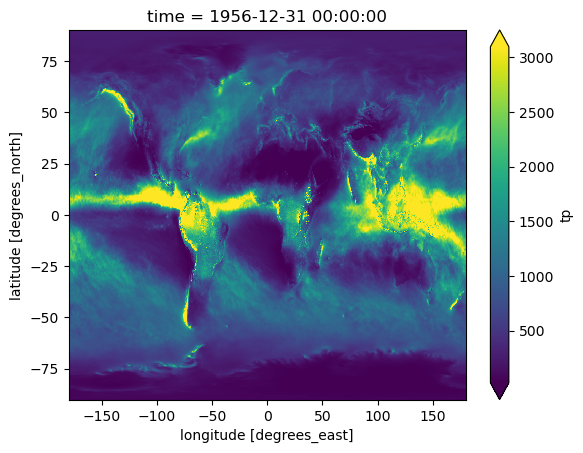

In [190]:
data_ds.isel(time=16).plot(robust=True)

In [45]:
var_name

In [186]:
data_ds.attrs = {
    **data_ds.attrs,
    "dataset_name": 'era5',
    'variable': var_name,
    'save_chunks' : CHUNKS_FOR_ERA5,
    'info':("tp (total precipitation) reampled to daily"
            "sum then resample to yearly max")
}

In [191]:
data_ds.to_zarr(output_file, mode='w')

### Opening

In [192]:
MY_ERA5_PATH = os.path.join(paths.DATA_DIR, 'era5')
output_file = Path(os.path.join(MY_ERA5_PATH, f"{variable}.zarr"))
output_file

PosixPath('/g/data/w40/ab2313/time_of_emergence/era5/tp.zarr')

In [193]:
data_ds = xr.open_zarr(str(output_file), chunks=CHUNKS_FOR_ERA5)[variable]#.to_array()#[var_name]

In [203]:
data_ds = data_ds.isel(time=slice(None, -1))

<h2 style='color:cyan'> Data Check </h2>

In [195]:
data_ds = data_ds.transpose(..., "time").chunk(chunks).persist()
wait(data_ds)

DoneAndNotDoneFutures(done={<Future: finished, type: numpy.ndarray, key: ('transpose-e0cc3530ba9e1c7910971318a5397d62', 2, 5, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-e0cc3530ba9e1c7910971318a5397d62', 0, 11, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-e0cc3530ba9e1c7910971318a5397d62', 6, 1, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-e0cc3530ba9e1c7910971318a5397d62', 6, 22, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-e0cc3530ba9e1c7910971318a5397d62', 0, 16, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-e0cc3530ba9e1c7910971318a5397d62', 4, 9, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-e0cc3530ba9e1c7910971318a5397d62', 2, 18, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-e0cc3530ba9e1c7910971318a5397d62', 0, 20, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-e0cc3530ba9e1c7910971318a5397d62', 0, 3, 0)>, <Future: finished, type: numpy.ndarray, 

In [53]:
chunks

{'time': -1, 'lat': 18, 'lon': 72}

In [196]:
data_ds

<xarray.DataArray 'tp' (lat: 721, lon: 1440, time: 85)> Size: 706MB
dask.array<transpose, shape=(721, 1440, 85), dtype=float64, chunksize=(103, 60, 85), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 680B 1940-12-31 1941-12-31 ... 2024-12-31

In [204]:
# Make sure chunks is 1
assert len(data_ds.chunksizes['time']) == 1

In [205]:
# data_ds.mean(dim=['lat', 'lon']).plot()
data_ds.sum(dim=['lat', 'lon']).plot()

In [206]:
plt.hist(data_ds.sel(lat=-38, lon=145, method='nearest').squeeze().values, edgecolor='k');

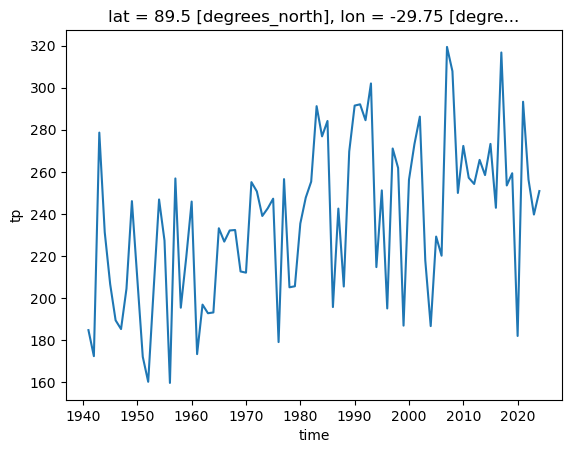

In [207]:
data_ds.sel(lat=89.5, lon=-29.75, method='nearest').plot()

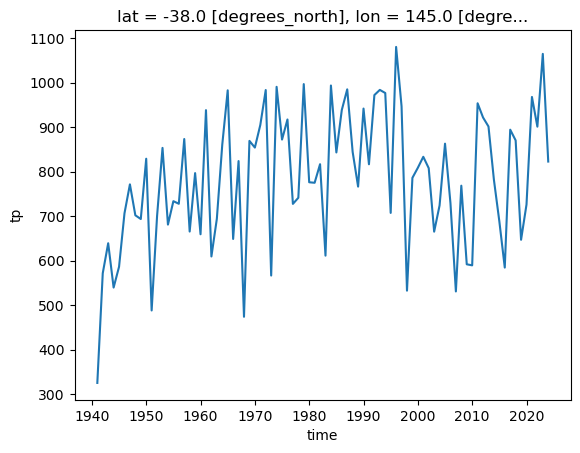

In [208]:
data_ds.sel(lat=-38, lon=145, method='nearest').plot()

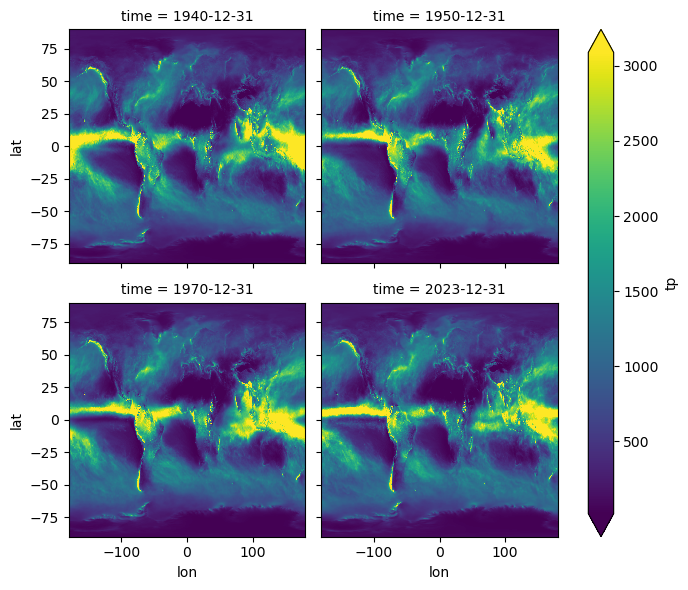

In [209]:
data_ds.isel(time=[0, 10, 30, -1]).plot(col='time', col_wrap=2, robust=True)

In [210]:
# Calculate statistics
min_val = data_ds.min().values.item()
q25_val = data_ds.reduce(np.nanpercentile, q=25).values.item()
q75_val = data_ds.reduce(np.nanpercentile, q=75).values.item()
max_val = data_ds.max().values.item()

# Display nicely
print(f"Statistics:\n"
      f"Min: {min_val:.2f}\n"
      f"25th Percentile: {q25_val:.2f}\n"
      f"75th Percentile: {q75_val:.2f}\n"
      f"Max: {max_val:.2f}")

Statistics:
Min: -0.00
25th Percentile: 283.01
75th Percentile: 1171.54
Max: 35461.65


In [211]:
len(data_ds.time.values), np.take(data_ds.time.values, [0, 1,2, -3, -2, -1])

(84,
 array(['1940-12-31T00:00:00.000000000', '1941-12-31T00:00:00.000000000',
        '1942-12-31T00:00:00.000000000', '2021-12-31T00:00:00.000000000',
        '2022-12-31T00:00:00.000000000', '2023-12-31T00:00:00.000000000'],
       dtype='datetime64[ns]'))

In [212]:
# Remove data that occurs before this
data_ds = data_ds.sel(time=data_ds.time.dt.year>=base_period.start)
data_ds

<xarray.DataArray 'tp' (lat: 721, lon: 1440, time: 84)> Size: 698MB
dask.array<getitem, shape=(721, 1440, 84), dtype=float64, chunksize=(103, 60, 84), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 672B 1940-12-31 1941-12-31 ... 2023-12-31

In [213]:
len(data_ds.time.values), np.take(data_ds.time.values, [0, 1,2, -3, -2, -1])

(84,
 array(['1940-12-31T00:00:00.000000000', '1941-12-31T00:00:00.000000000',
        '1942-12-31T00:00:00.000000000', '2021-12-31T00:00:00.000000000',
        '2022-12-31T00:00:00.000000000', '2023-12-31T00:00:00.000000000'],
       dtype='datetime64[ns]'))

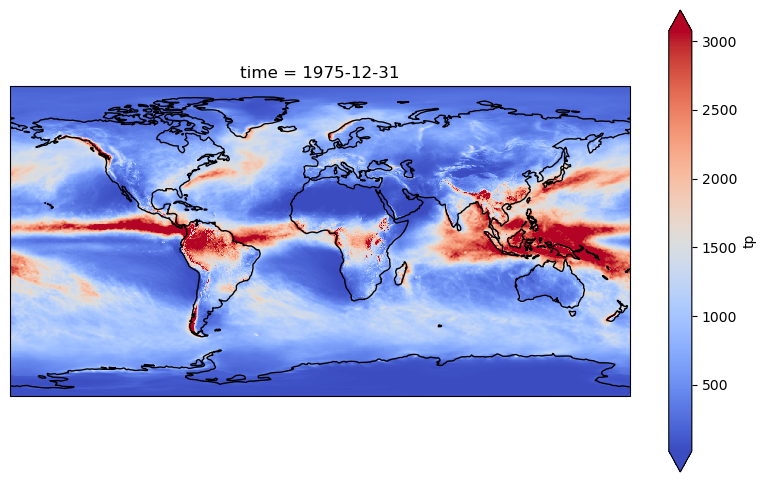

In [214]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
data_ds.isel(time=35).plot(ax=ax,robust=True, cmap='coolwarm')
ax.coastlines()
# ax.set_title('Year 2000')

In [215]:
base_period_ds = data_ds.where(data_ds.time.dt.year.isin(np.arange(*base_period.value)), drop=True)
base_period_ds

<xarray.DataArray 'tp' (lat: 721, lon: 1440, time: 30)> Size: 249MB
dask.array<where, shape=(721, 1440, 30), dtype=float64, chunksize=(103, 60, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 240B 1940-12-31 1941-12-31 ... 1969-12-31

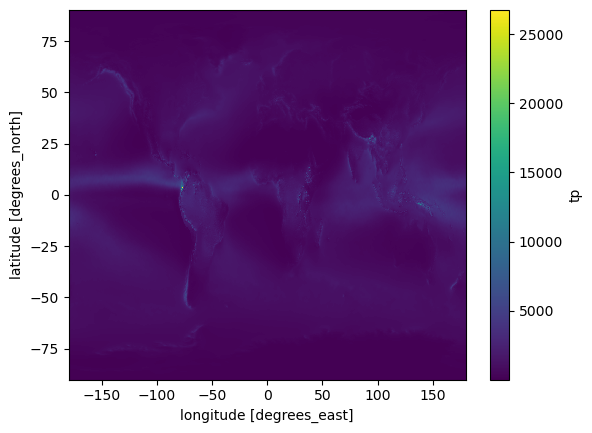

In [216]:
base_period_ds.mean(dim='time').plot()

In [217]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
base_period_ds_count = base_period_ds.count(dim='time')
# How many years are needed for 80 percent
percent_80_of_years = 0.8*(base_period.end - base_period.start)
data_availability_mask = xr.where(base_period_ds_count>=percent_80_of_years, 1, 0)
data_availability_mask

<xarray.DataArray 'tp' (lat: 721, lon: 1440)> Size: 8MB
dask.array<where, shape=(721, 1440), dtype=int64, chunksize=(103, 60), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8

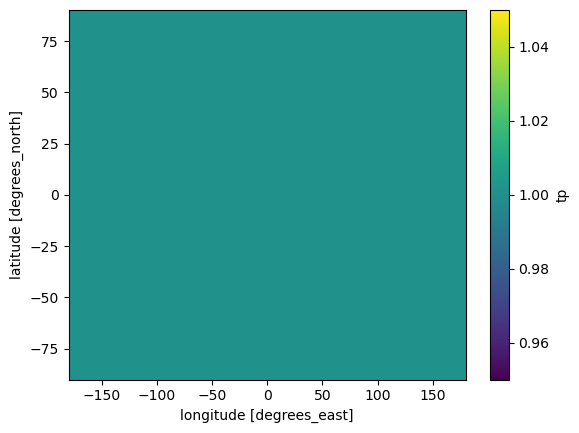

In [218]:
data_availability_mask.plot()

In [219]:
# Apply the mask to both the base period and the full dataset
data_ds = data_ds.where(data_availability_mask)
base_period_ds = base_period_ds.where(data_availability_mask)

In [220]:
# Resetting the anomlies to 1850
data_anom_ds = data_ds - base_period_ds.mean(dim='time')
base_period_anom_ds = base_period_ds - base_period_ds.mean(dim='time')

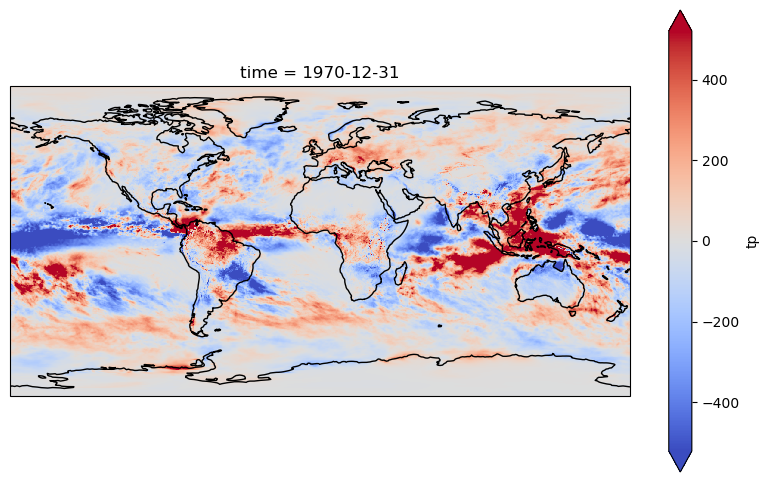

In [221]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
data_anom_ds.isel(time=30).plot(ax=ax,robust=True, cmap='coolwarm')
ax.coastlines()
# ax.set_title('Year 2000')

In [222]:
data_anom_ds.sel(lat=-38, lon=145, method='nearest').plot()

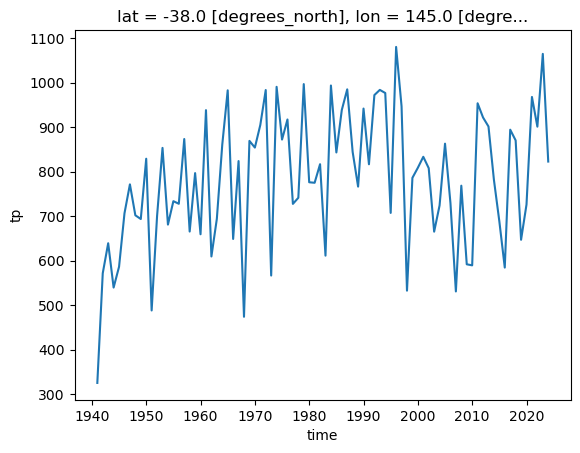

In [223]:
data_ds.sel(lat=-38, lon=145, method='nearest').plot()

<h1 style='color: yellow'> Metric Calculation </h1>

<h2 style='color: cyan'>Dataset set-up </h2>

<ul>
    <li> Scaling client</li>
    <li> Chunking data set</li>
</ul>

In [224]:
window = 30

In [225]:
CHUNKS_FOR_PVALUE_TESTS = chunks

In [226]:
data_ds_window = (data_ds
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
                  .persist()
                 ) 

base_period_window_ds = (base_period_ds
                         .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist()
                        )

In [227]:
wait(data_ds_window);
wait(base_period_window_ds);

In [228]:
data_ds_window

<xarray.DataArray 'tp' (lat: 721, lon: 1440, time: 84, window_dim: 30)> Size: 21GB
dask.array<rechunk-merge, shape=(721, 1440, 84, 30), dtype=float64, chunksize=(103, 60, 84, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 672B 1940-12-31 1941-12-31 ... 2023-12-31
Dimensions without coordinates: window_dim

In [229]:
data_ds_window.chunks

((103, 103, 103, 103, 103, 103, 103),
 (60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60),
 (84,),
 (30,))

In [230]:
base_period_window_ds

<xarray.DataArray 'tp' (lat: 721, lon: 1440, window_dim: 30)> Size: 249MB
dask.array<where, shape=(721, 1440, 30), dtype=float64, chunksize=(103, 60, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat         (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon         (lon) float32 6kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * window_dim  (window_dim) datetime64[ns] 240B 1940-12-31 ... 1969-12-31

In [231]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [232]:
# # P-value methods works better with a large cluster.
# # Small chunks with large computation
client.cluster.scale(200);
sleep(7);

<h2 style='color: cyan'> Overlap Methods - Optimized</h2>

In [233]:
kde_kwargs= dict(bw_method=0.2) # silverman, scott#bw_method=0.2)

### Perkins

In [234]:
data_arr = data_ds.values.flatten()
data_arr = data_arr[data_arr != 0]

In [235]:
bins = toe_calc.calculate_freedman_diaconis_bins(data_arr, length=len(data_ds.time.values),
                                                logginglevel='DEBUG')

np.unique(np.diff(bins).round(6)).item(), bins

p75=1171.5405430461178, p25=283.0158604253196, iqr=888.5246826207982, length=84
 - 405.76358008269534


(405.76358,
 array([   -0.  ,   405.76,   811.53,  1217.29,  1623.05,  2028.82,
         2434.58,  2840.35,  3246.11,  3651.87,  4057.64,  4463.4 ,
         4869.16,  5274.93,  5680.69,  6086.45,  6492.22,  6897.98,
         7303.74,  7709.51,  8115.27,  8521.04,  8926.8 ,  9332.56,
         9738.33, 10144.09, 10549.85, 10955.62, 11361.38, 11767.14,
        12172.91, 12578.67, 12984.43, 13390.2 , 13795.96, 14201.73,
        14607.49, 15013.25, 15419.02, 15824.78, 16230.54, 16636.31,
        17042.07, 17447.83, 17853.6 , 18259.36, 18665.12, 19070.89,
        19476.65, 19882.42, 20288.18, 20693.94, 21099.71, 21505.47,
        21911.23, 22317.  , 22722.76, 23128.52, 23534.29, 23940.05,
        24345.81, 24751.58, 25157.34, 25563.11, 25968.87, 26374.63,
        26780.4 , 27186.16, 27591.92, 27997.69, 28403.45, 28809.21,
        29214.98, 29620.74, 30026.5 , 30432.27, 30838.03, 31243.8 ,
        31649.56, 32055.32, 32461.09, 32866.85, 33272.61, 33678.38,
        34084.14, 34489.9 , 34895.67

In [3]:
np.min(bins), np.max(bins)
np.min(data_arr), np.max(data_arr)

<function ptp at 0x15404dadf930>

In [236]:
# Example latitudes and longitudes range (adjust as needed)
lats = np.linspace(-38.5, -37.5, 3)  # Replace with your actual latitudes
lons = np.linspace(144.5, 146.5, 3)  # Replace with your actual longitudes

# Create a 3x3 plot grid
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Loop through latitudes and longitudes
for i, lat in enumerate(lats):
    for j, lon in enumerate(lons):
        # Extract the data for the current lat, lon
        test_data = data_ds.sel(lat=lat, lon=lon, method='nearest').values
        
        # Compute the KDE
        _, rel_freq = toe_calc.discrete_pdf(test_data, bins=bins)
        x_test, kde_test = toe_calc.create_kde(test_data, **kde_kwargs)

        # Plot on the current subplot
        ax = axs[i, j]
        ax2 = ax.twinx()
        ax.bar(bins[:-1], rel_freq, width=np.diff(bins), align='edge', edgecolor='k')
        ax2.plot(x_test, kde_test, color='r')
        ax.set_title(f'Lat: {lat}, Lon: {lon}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        valid_bins = bins[:-1][rel_freq > 0]
        x_min, x_max = valid_bins.min()-5*np.diff(bins)[0], valid_bins.max()+5*np.diff(bins)[0]
        ax.set_xlim(x_min, x_max)

In [237]:
%%time
# Pre-calculate the relative frequency of the base period

base_period_rel_freq_ds = xr.apply_ufunc(
    toe_calc.get_rel_freq,
    base_period_ds,
    input_core_dims=[['time']],
    output_core_dims=[['bins']],
    kwargs={'bins': bins},
    vectorize=True,
    dask='parallelized',
    output_sizes={'bins': len(bins) - 1}, 
    output_dtypes=float
).persist()
wait(base_period_rel_freq_ds)

CPU times: user 2.3 s, sys: 1.78 s, total: 4.08 s
Wall time: 4.05 s


DoneAndNotDoneFutures(done={<Future: finished, type: numpy.ndarray, key: ('transpose-61ad2cb559c7ab5063dfa864f2edbb18', 0, 14, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-61ad2cb559c7ab5063dfa864f2edbb18', 6, 13, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-61ad2cb559c7ab5063dfa864f2edbb18', 4, 7, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-61ad2cb559c7ab5063dfa864f2edbb18', 6, 17, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-61ad2cb559c7ab5063dfa864f2edbb18', 3, 18, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-61ad2cb559c7ab5063dfa864f2edbb18', 1, 17, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-61ad2cb559c7ab5063dfa864f2edbb18', 5, 11, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-61ad2cb559c7ab5063dfa864f2edbb18', 6, 7, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-61ad2cb559c7ab5063dfa864f2edbb18', 4, 2, 0)>, <Future: finished, type: numpy.ndarray,

In [238]:
%%time
perkins_ds = xr.apply_ufunc(
    toe_calc.perkins_skill_score_base_bins,
    data_ds_window,
    base_period_rel_freq_ds,
    kwargs={'bins': bins},
    input_core_dims=[['window_dim'], ['bins']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
    ).compute()

CPU times: user 21.9 s, sys: 16.5 s, total: 38.4 s
Wall time: 50.4 s


In [239]:
perkins_ds = perkins_ds.sortby('lat')

In [240]:
perkins_ds.attrs = {
    'window': window,
    **perkins_ds.attrs,
    'bins': 
    {
        'start':bins.round(4)[0],
        'stop':bins.round(4)[-1],
        'step': np.unique(np.diff(bins)).round(4)[0]}
}

In [241]:
location = dict(lat=69, lon=-165, method='nearest')

In [242]:
perkins_ds.sel(**location).plot()

In [243]:
base_arr = base_period_ds.sel(**location).values
rel_freq_base = toe_calc.rel_freq(base_arr, bins)
future_arr = data_ds.sel(**location).where(
    data_ds.time.dt.year.isin(np.arange(base_period.start, base_period.start+window)), drop=True).values
rel_freq_future = toe_calc.rel_freq(future_arr, bins=bins)

In [244]:
toe_calc.discrete_distribution_overlap(rel_freq_base, rel_freq_future),\
toe_calc.perkins_skill_score(future_arr, base_arr, bins=bins),\
perkins_ds.sel(**location).isel(time=10).values.item()

(100.0, 100.0, 98.0)

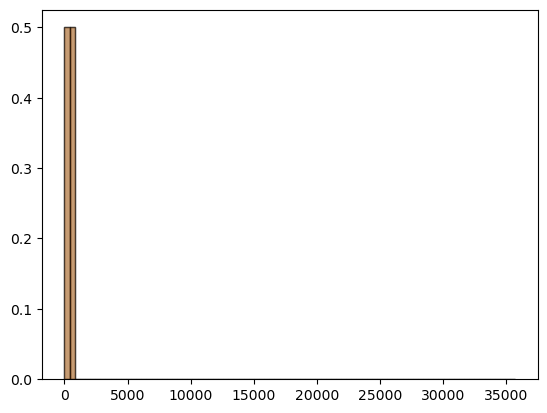

In [245]:
fig, ax = plt.subplots(1, 1)
diagnostic_tools.plot_bar(bins, rel_freq_base, ax=ax)
diagnostic_tools.plot_bar(bins, rel_freq_future, ax=ax)

In [246]:
toe_calc.perkins_skill_score_base_bins(
    data_ds_window.sel(lat=-39, lon=145,method='nearest').isel(time=slice(None, 30)).values,
    base_period_rel_freq_ds.sel(lat=-39, lon=145,method='nearest').values,
    bins=bins
)

93.2051282051282

<BarContainer object of 88 artists>

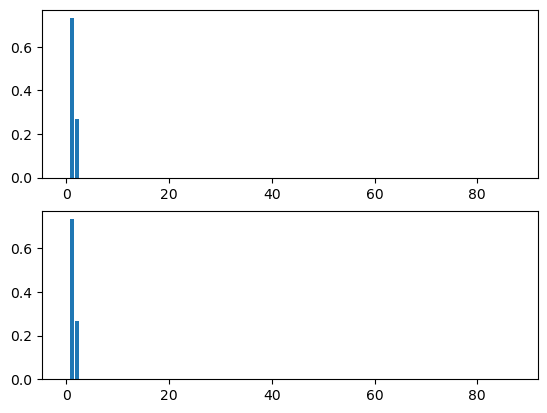

In [247]:
fig, (ax1, ax2) = plt.subplots(2, 1)

test_loc = dict(lat=-39, lon=145, method='nearest')
rel_freq_test = toe_calc.get_rel_freq(base_period_ds.sel(**test_loc).squeeze().values, bins=bins)

ax1.bar(base_period_rel_freq_ds.bins.values, rel_freq_test)
ax2.bar(base_period_rel_freq_ds.bins.values, base_period_rel_freq_ds.sel(**test_loc).values)

 - locator: <matplotlib.ticker.FixedLocator object at 0x1506e0a49e10>


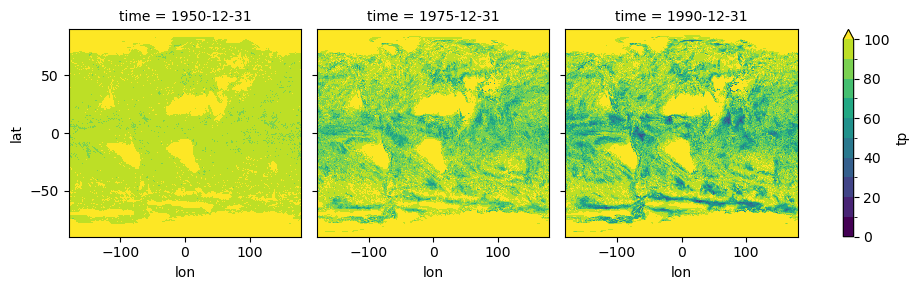

In [248]:
perkins_ds.isel(time=[10, 35, 50]).plot(col='time', levels=np.arange(0, 110, 10))

### KDE Metrics

In [249]:
def create_kde_x_exists(arr: np.ndarray, x: np.ndarray, **kwargs):
    """
    Create a KDE for the given array and evaluate it at the specified points.

    Parameters:
    - arr: np.ndarray, input data for KDE computation.
    - x: np.ndarray, points at which to evaluate the KDE.
    - kwargs: Additional arguments to pass to scipy.stats.gaussian_kde.

    Returns:
    - kde_vals: np.ndarray, normalized KDE values evaluated at `x`.
    """
    if np.all(np.isnan(arr)): return np.tile(np.nan, len(x))
    
    # Remove NaN and infinite values from the array
    arr = arr[np.isfinite(arr)]

    if np.ptp(arr) <= 0.1: # The values differ by less than 0.1
        # Jitter the values by an amount of 10^-6
        arr = arr + np.random.normal(0, 1e-6, size=arr.shape)
    
    # Compute the KDE
    try:
        kde = toe_calc.gaussian_kde(arr, **kwargs)
    except np.linalg.LinAlgError as e:
        return np.tile(np.nan, len(x))
    kde_vals = kde(x)

    # Normalize the KDE values to ensure total area equals 1
    kde_vals /= np.trapz(kde_vals, x)

    return kde_vals


In [250]:
def calculate_kde_overlap(dist1, dist2, x):
    """
    Calculate the percentage overlap between two probability density functions (KDEs).
    
    Parameters:
    - dist1: array-like, first KDE values evaluated on x.
    - dist2: array-like, second KDE values evaluated on x.
    - x: array-like, the points where dist1 and dist2 are evaluated.
    
    Returns:
    - overlap_percent: float, percentage overlap between the two distributions.
    """
    # Calculate the overlap shape by taking the minimum of the two KDEs at each point
    overlap_shape = np.minimum(dist1, dist2)
    
    # Integrate the overlap shape to find the overlap area
    overlap_area = np.trapz(overlap_shape, x)
    
    # Convert the overlap area to a percentage (assuming KDEs are normalized)
    overlap_percent = overlap_area * 100

    return overlap_percent


In [251]:
def __overlap_helper_function_base_fitted(
    arr_future: np.ndarray, kde_base: np.ndarray,
    overlap_function, x, method_kwargs=None) -> float:
    """
    Helper function to calculate the overlap between the KDEs of two arrays using a specified overlap function.

    Parameters:
    arr_future (numpy.ndarray): First input array of values.
    arr_base (numpy.ndarray): Second input array of values.
    return_all (bool): If False (default) just return the overlap percent. If True,
                        return the KDEs and the overlap percent.
    kde_kwargs (dict, optional): Keyword arguments to pass to the KDE creation function.
    bmax (float, optional): Maximum value for the range of the KDE.
    bmin (float, optional): Minimum value for the range of the KDE.
    overlap_function (callable, optional): Function to calculate overlap between two distributions.
                                           Should accept `kde_base`, `kde_future`, and `x` as arguments.

    Returns:
    float: Overlap area as calculated by the specified overlap function. Returns NaN if any array is fully NaN.
    """
    if not method_kwargs: method_kwargs = {}

    # Check if any input array is fully NaN
    if np.all(np.isnan(arr_future)) or np.all(np.isnan(kde_base)): return np.nan

    kde_future = create_kde_x_exists(arr_future, x, **method_kwargs)
    
    out_metric = overlap_function(kde_base, kde_future, x)
    return out_metric

In [252]:
fractional_geometric_area_optimized = partial(
    __overlap_helper_function_base_fitted,
    overlap_function=calculate_kde_overlap)

In [253]:
hellinger_distance_optimized = partial(
    __overlap_helper_function_base_fitted,
    overlap_function=toe_calc.calculate_hellinger_distance)

In [254]:
# The x-values for the KDE are based upon the max and min
data_max = data_ds.max().persist().values.item()
data_min = data_ds.min().persist().values.item()
num_points = 1000
x = toe_calc.create_x(bmin=data_min, bmax=data_max, num_points=num_points)

data_min, data_max, x.shape

 - full garbage collections took 11% CPU time recently (threshold: 10%)


(-1.7569279364693102e-11, 35461.64503410851, (1000,))

In [255]:
%%time
# Pre-calculate the base period KDE

base_period_kde = xr.apply_ufunc(
    create_kde_x_exists,
    base_period_ds,
    input_core_dims=[['time'], ],
    output_core_dims=[['x']],
    kwargs={'x': x, **kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_sizes={'x':len(x)},  # Specify the size of the 'bin' dimension
    output_dtypes=float
).persist()
wait(base_period_kde);

CPU times: user 4.49 s, sys: 3.39 s, total: 7.87 s
Wall time: 9.44 s


In [256]:
# # latlon_dict = dict(lat=-38, lon=145, method='nearest')
# # latlon_dict = dict(lat=-38, lon=145, method='nearest')
latlon_dict = dict(lat=-89.5, lon=-29.75, method='nearest')
hellinger_distance_optimized(
    arr_future=data_ds_window.sel(**latlon_dict).isel(time=slice(30, 60)).values,
    kde_base = base_period_kde.sel(**latlon_dict).values,
    x=x
)

1.0996540599940216e-07

In [257]:
%%time
hellinger_ds = xr.apply_ufunc(
    hellinger_distance_optimized,
    data_ds_window,
    base_period_kde,
    input_core_dims=[['window_dim'], ['x']],
    exclude_dims={'window_dim'},
    kwargs={'x': x, 'method_kwargs':kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
).compute()

/jobfs/132738486.gadi-pbs/ipykernel_3788291/426398749.py:30: RuntimeWarning: invalid value encountered in divide
/jobfs/132738486.gadi-pbs/ipykernel_3788291/426398749.py:30: RuntimeWarning: invalid value encountered in divide


CPU times: user 1min 53s, sys: 1min 55s, total: 3min 48s
Wall time: 7min 34s


In [258]:
%%time
frac_geom_ds = xr.apply_ufunc(
    fractional_geometric_area_optimized,
    data_ds_window,
    base_period_kde,
    input_core_dims=[['window_dim'], ['x']],
    exclude_dims={'window_dim'},
    kwargs={'x': x, 'method_kwargs':kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
).compute()
# wait(frac_geom_ds2)

/jobfs/132738486.gadi-pbs/ipykernel_3788291/426398749.py:30: RuntimeWarning: invalid value encountered in divide
/jobfs/132738486.gadi-pbs/ipykernel_3788291/426398749.py:30: RuntimeWarning: invalid value encountered in divide


CPU times: user 1min 49s, sys: 1min 51s, total: 3min 40s
Wall time: 7min 46s


In [259]:
x_attrs = { 'bmin': data_min, 'bmax':data_max, 'num_points': num_points}
frac_geom_ds.attrs = {'window': window,**frac_geom_ds.attrs, **kde_kwargs, **x_attrs}
hellinger_ds.attrs =  {'window': window, **hellinger_ds.attrs, **kde_kwargs, **x_attrs}

In [260]:
hellinger_ds.attrs

{'window': 30,
 'bw_method': 0.2,
 'bmin': -1.7569279364693102e-11,
 'bmax': 35461.64503410851,
 'num_points': 1000}

 - locator: <matplotlib.ticker.FixedLocator object at 0x1508f81affa0>


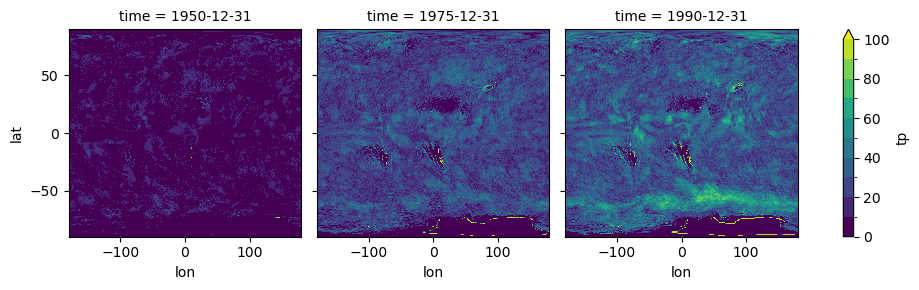

In [261]:
hellinger_ds.isel(time=[10, 35, 50]).plot(col='time', levels=np.arange(0, 110, 10))

 - locator: <matplotlib.ticker.FixedLocator object at 0x1507966a1ae0>


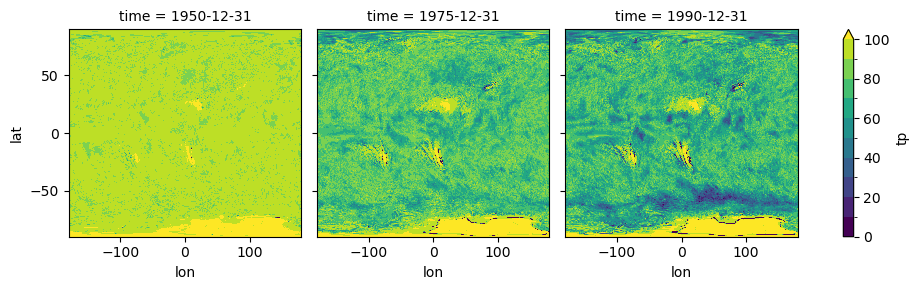

In [262]:
frac_geom_ds.isel(time=[10, 35, 50]).plot(col='time', levels=np.arange(0, 110, 10))

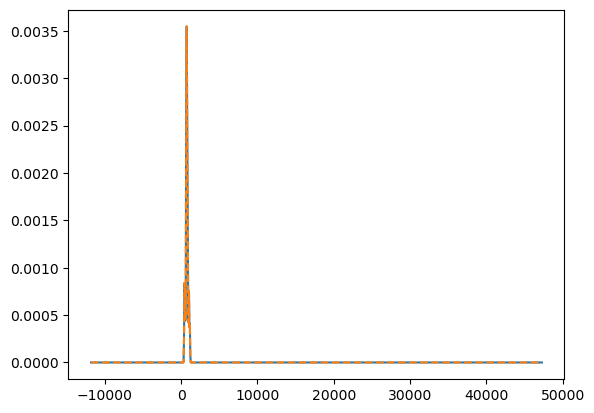

In [263]:
fig, ax1 = plt.subplots(1, 1)

test_loc = dict(lat=-39, lon=145, method='nearest')

test_kde = create_kde_x_exists(base_period_ds.sel(**test_loc).values, x, **kde_kwargs)

ax1.plot(x, base_period_kde.sel(**test_loc).values)
ax1.plot(x, test_kde, linestyle='--')

### Old - Ufunc

In [264]:
# %%time
# perkins_ds = xr.apply_ufunc(
#     toe_calc.perkins_skill_score,
#     data_ds_window,
#     base_period_window_ds,
#     kwargs={'bins': bins},
#     output_dtypes=float,
#     **rolling_window_kwargs
#     ).compute().sortby('lat')

In [265]:
# %%time
# frac_geom_ds = xr.apply_ufunc(
#     toe_calc.fractional_geometric_area,
#     data_ds_window,
#     base_period_window_ds,
#     kwargs = dict(method_kwargs=kde_kwargs),
#     output_dtypes=float,
#     **rolling_window_kwargs
#     ).compute()

In [266]:
# %%time
# hellinger_ds = xr.apply_ufunc(
#     toe_calc.hellinger_distance,
#     data_ds_window,
#     base_period_window_ds,
#     kwargs = dict(method_kwargs=kde_kwargs),
#     output_dtypes=float,
#     **rolling_window_kwargs
#     ).compute()

<h2 style='color: cyan'> P-value Methods </h2>

1d Array Method <br>

This method comapes starting from the begging and looops through. The nans are added to the end so the length matches

In [267]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [268]:
%%time
# Expected: 9 minutes 30 seconds
ttest_ds = xr.apply_ufunc(
        toe_calc.return_ttest_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 4min 41s, sys: 4min 46s, total: 9min 27s
Wall time: 18min 54s


In [269]:
ttest_ds

<xarray.DataArray 'tp' (lat: 721, lon: 1440, time: 84)> Size: 698MB
array([[[0.76, ..., 0.  ],
        ...,
        [0.76, ..., 0.  ]],

       ...,

       [[0.11, ..., 0.  ],
        ...,
        [0.11, ..., 0.  ]]])
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 672B 1940-12-31 1941-12-31 ... 2023-12-31

In [270]:
%%time
# Expected 3 minutes 30 seconds - best
# 6 23 - era5
ks_ds = xr.apply_ufunc(
        toe_calc.return_ks_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


CPU times: user 1min 20s, sys: 1min 17s, total: 2min 38s
Wall time: 5min 5s


In [271]:
ks_ds

<xarray.DataArray 'tp' (lat: 721, lon: 1440, time: 84)> Size: 698MB
array([[[0.99, ..., 0.  ],
        ...,
        [0.99, ..., 0.  ]],

       ...,

       [[0.81, ..., 0.03],
        ...,
        [0.81, ..., 0.03]]])
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 672B 1940-12-31 1941-12-31 ... 2023-12-31

In [272]:
# ks_2samp will perfom on all nan slices
# ks_ds = ks_ds.where(data_availability_mask)

In [273]:
# %%time
# anderson_ds = xr.apply_ufunc(
#     toe_calc.return_anderson_pvalue,
#     data_ds_window,
#     base_period_window_ds,
#     output_dtypes=float, 
#     **rolling_window_kwargs
#     ).compute()

### Verification of p-value test
- Comparison with 1d rolling func
Verifyting the abstracted (but faster) methods works by comparing to a single lat, lon point.

In [274]:
lat_lon_sp = dict(lat=-34, lon=145, method='nearest')

In [275]:
stats_test_1d_array_ks = partial(
    toe_calc.stats_test_1d_array, stats_func=toe_calc.return_ks_pvalue,
    window=window, base_period_length = base_period.end-base_period.start)

In [276]:
ks_1d_1p = stats_test_1d_array_ks(data_ds.sel(**lat_lon_sp).values)

In [277]:
plt.plot(ks_1d_1p,label='1d', linestyle='--')
plt.plot(ks_ds.sel(**lat_lon_sp).isel(time=slice(int(window/2), -int(window/2))).values, label='roll', alpha=0.5)
plt.legend()

<h2 style='color: cyan'> Signal-to-Noise </h2>

<b> Hawkins S/N Ratio</b>

In [278]:
# Calculate the wegithed mean
data_ds_smean = climate_utils.weighted_lat_lon_mean(data_anom_ds).compute()

In [279]:
data_ds_smean.plot()

In [280]:
# Get lowess filtered version
ds_smean_lowess = my_stats.trend_fit(data_ds_smean, method='LOWESS', lowess_window=41)

In [281]:
%%time
return_hawkins_signal_and_noise_partial = partial(toe_calc.return_hawkins_signal_and_noise, 
                                                  gt=ds_smean_lowess.values)

ds_signal_hawkins, ds_noise_series_hawkins = xr.apply_ufunc(
    return_hawkins_signal_and_noise_partial,
    data_anom_ds,
    input_core_dims=[['time']], 
    output_core_dims=[['time'], ['time']], 
    dask='parallelized', 
    vectorize=True,
    output_dtypes=[float, float],
)

ds_signal_hawkins = ds_signal_hawkins.compute()
ds_noise_series_hawkins = ds_noise_series_hawkins.compute()

CPU times: user 13.3 s, sys: 8.73 s, total: 22 s
Wall time: 21.6 s


In [282]:
# Noise 
ds_noise_hawkins_full = ds_noise_series_hawkins.std(dim='time').compute()

ds_noise_hawkins_base_period = ds_noise_series_hawkins.where(
    ds_noise_series_hawkins.time.dt.year.isin(np.arange(*base_period.value)), drop=True).std(dim='time')

# S/N Ratio 
ds_sn_hawkins_full = ds_signal_hawkins/ds_noise_hawkins_full
ds_sn_hawkins_base_period = ds_signal_hawkins/ds_noise_hawkins_base_period

<b> Lowess S/N </b>

In [283]:
ds_signal_lowess = xr.apply_ufunc(
    my_stats.apply_lowess, 
    data_anom_ds.chunk({'time':-1, 'lat':10}), 
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True, 
    dask='parallelized',    
).compute()

In [284]:
# Noise series is detrended data
ds_noise_series_lowess = (data_anom_ds - ds_signal_lowess).compute()
# Noise is std of detrended data
ds_noise_lowess_full = ds_noise_series_lowess.std(dim='time')

ds_noise_lowess_base_period = ds_noise_series_lowess.where(
    ds_noise_series_lowess.time.dt.year.isin(np.arange(*base_period.value)), drop=True).std(dim='time')

# S/N Ratio
ds_sn_lowess_full = ds_signal_lowess/ds_noise_lowess_full
ds_sn_lowess_base_period = ds_signal_lowess/ds_noise_lowess_base_period

### Plot Verificaiton

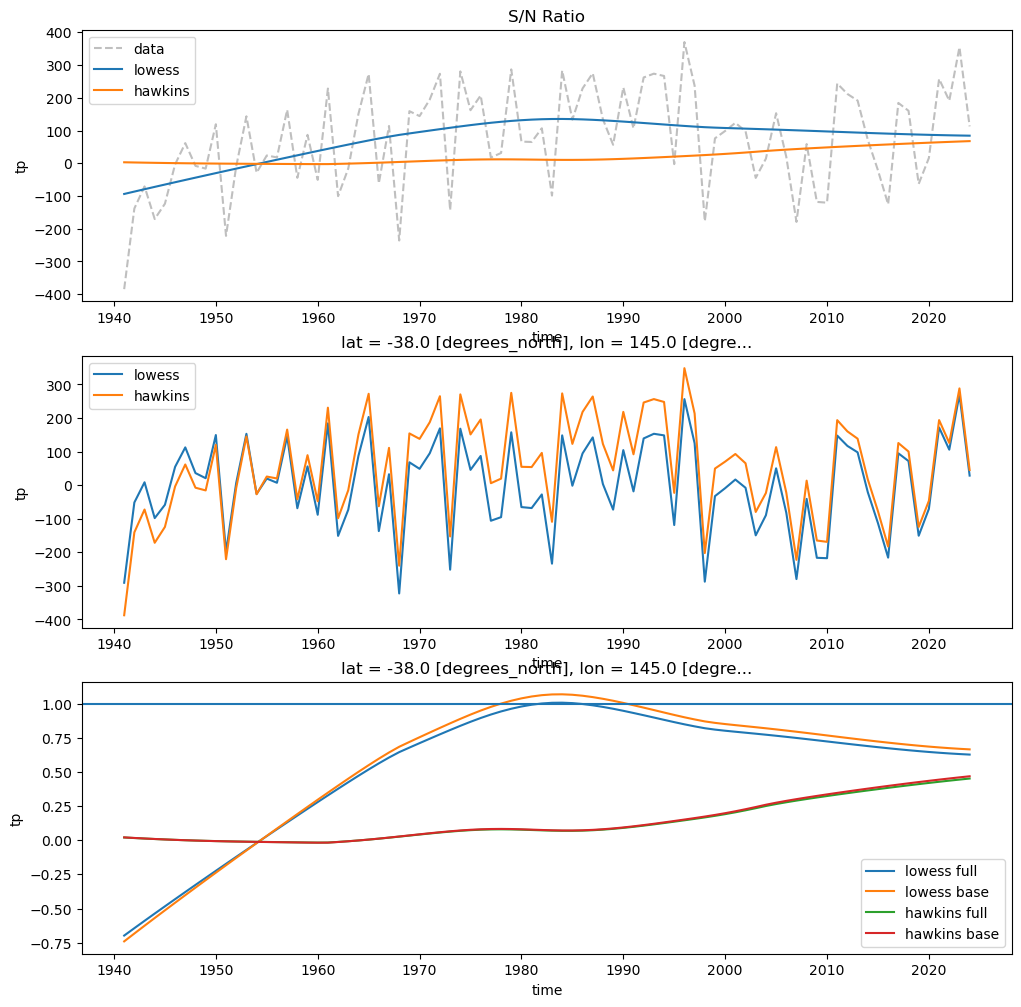

In [285]:
lat_lon_sp = dict(lat=-38, lon=145, method='nearest')

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

ax1 = axes[0]
data_anom_ds.sel(**lat_lon_sp).plot(label='data', ax=ax1, color='grey', linestyle='--', alpha=0.5)
ds_signal_lowess.sel(**lat_lon_sp).plot(label='lowess', ax=ax1)
ds_signal_hawkins.sel(**lat_lon_sp).plot(label='hawkins', ax=ax1)
ax1.set_title('Signal')
ax1.legend()

ax2= axes[1]
ds_noise_series_lowess.sel(**lat_lon_sp).plot(label='lowess', ax=ax2)
ds_noise_series_hawkins.sel(**lat_lon_sp).plot(label='hawkins', ax=ax2)
ax1.set_title('Noise Series')

ax2.legend()

ax3= axes[2]
ds_sn_lowess_full.sel(**lat_lon_sp).plot(label='lowess full', ax=ax3)
ds_sn_lowess_base_period.sel(**lat_lon_sp).plot(label='lowess base', ax=ax3)

ds_sn_hawkins_full.sel(**lat_lon_sp).plot(label='hawkins full', ax=ax3)
ds_sn_hawkins_base_period.sel(**lat_lon_sp).plot(label='hawkins base', ax=ax3)
ax1.set_title('S/N Ratio')
ax3.axhline(1)
ax3.legend()

In [286]:
ds_signal_lowess.isel(time=[0, 30, 50]).plot(col='time', robust=True)

In [287]:
# Rolling noise variant
# ds_data_noise_lowess_rolling = ds_data_noise_series_lowess.rolling(time=window, min_periods=2).std(dim='time').compute()
# First time step is nan, so remove
# ds_data_noise_lowess_rolling = ds_data_noise_lowess_rolling.isel(time=slice(1, None))
# This is odd. But I am making the fire 19 years (wnindow lenght) have the same noise as the first time the 
# variability can be calculated.
# ds_data_noise_lowess_rolling = xr.concat([
#     ds_data_noise_lowess_rolling.isel(time=slice(0, window-2)).fillna(ds_data_noise_lowess_rolling.isel(time=window-1)),
#     ds_data_noise_lowess_rolling.isel(time=slice(window-1, None))], dim='time')
# ds_data_noise_lowess_rolling = misc.adjust_time_from_rolling(ds_data_noise_lowess_rolling, window)

In [288]:
# ds_data_noise_lowess_rolling.sel(lat=-40, lon=144, method='nearest')

In [289]:
# ds_data_sn_lowess_rolling = ds_data_signal_lowess/ds_data_noise_lowess_rolling
# # First time step is nan for noise, so remove
# ds_data_sn_lowess_rolling = ds_data_sn_lowess_rolling.isel(time=slice(1, None))

In [290]:
# ds_data_noise_lowess_rolling.sel(lat=-38, lon=145, method='nearest').plot()

In [291]:
# ds_data_sn_lowess

In [292]:
# client.cluster.scale(6)
# sleep(7)

<h1 style='color: yellow'>  Data Mering and Save </h1>

In [293]:
ds_signal_lowess.name = 'signal_lowess'
ds_noise_series_lowess.name = 'noise_lowess'
ds_signal_hawkins.name = 'signal_hawkins'
ds_noise_series_hawkins.name = 'noise_hawkins'

In [294]:
ds_sn_hawkins_full.name = 'sn_hawkins_full'
ds_sn_hawkins_base_period.name = 'sn_hawkins_base'
ds_sn_lowess_full.name = 'sn_lowess_full'
ds_sn_lowess_base_period.name = 'sn_lowess_base'

ks_ds.name = 'ks'
ttest_ds.name = 'ttest'
perkins_ds.name = 'perkins'
frac_geom_ds.name = 'frac'
hellinger_ds.name = 'hd'

In [295]:
# Set long name attributes for each variable
ds_sn_hawkins_full.attrs['long_name'] = 'S/N Ratio (Hawkins, full)'
ds_sn_hawkins_base_period.attrs['long_name'] = 'S/N Ratio (Hawkins, base)'

ds_sn_lowess_full.attrs['long_name'] = 'S/N Ratio (LOWESS, full)'
ds_sn_lowess_base_period.attrs['long_name'] = 'S/N Ratio (LOWESS, base)'

ttest_ds.attrs['long_name'] = 'T-Test'
ks_ds.attrs['long_name'] = 'Kolmogorov-Smirnov'
perkins_ds.attrs['long_name'] = 'Perkins Skill Score'
frac_geom_ds.attrs['long_name'] = 'Fractional Geometric Area'
hellinger_ds.attrs['long_name'] = 'Hellinger Distance'

In [296]:
toe_metrics_ds = xr.merge([ks_ds, ttest_ds, perkins_ds, frac_geom_ds, hellinger_ds,
                           ds_sn_hawkins_full,ds_sn_hawkins_base_period,
                          ds_sn_lowess_full, ds_sn_lowess_base_period])

toe_metrics_ds = toe_metrics_ds.isel(time=slice(int(window/2), -int(window/2)))
toe_metrics_ds = toe_metrics_ds.compute()
toe_metrics_ds

<xarray.Dataset> Size: 4GB
Dimensions:          (lat: 721, lon: 1440, time: 54)
Coordinates:
  * lat              (lat) float32 3kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * lon              (lon) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * time             (time) datetime64[ns] 432B 1955-12-31 ... 2008-12-31
Data variables:
    ks               (lat, lon, time) float64 449MB 1.0 1.0 ... 5.795e-06
    ttest            (lat, lon, time) float64 449MB 1.0 0.806 ... 2.445e-06
    perkins          (lat, lon, time) float64 449MB 100.0 100.0 ... 100.0 100.0
    frac             (lat, lon, time) float64 449MB 100.0 100.0 ... 62.22 61.6
    hd               (lat, lon, time) float64 449MB 0.0 1.584e-29 ... 35.27
    sn_hawkins_full  (lat, lon, time) float64 449MB -0.02997 -0.0321 ... 1.16
    sn_hawkins_base  (lat, lon, time) float64 449MB -0.03592 -0.03847 ... 1.392
    sn_lowess_full   (lat, lon, time) float64 449MB 0.02672 -0.0006299 ... 1.561
    sn_lowess_base   (lat, lon, time) float64 449MB 0.03329 -0.0007847 ... 1.755
Attributes: (1)

In [297]:
dataset_name, variable, base_period

('era5', 'tp', <YearRange.ERA5_START: (1940, 1970)>)

In [298]:
VAR_SAVE_DIR

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/era5_tp_(1940_1970)'

In [299]:
# There is also a lot of processing that has been udnergone for this dataset.
# Worth saving just to keep complete consistency
DATA_SAVE_NAME = os.path.join(VAR_SAVE_DIR, f'data.zarr')
print(DATA_SAVE_NAME)
data_anom_ds.to_zarr(DATA_SAVE_NAME, mode='w')

/g/data/w40/ab2313/time_of_emergence/toe_metrics/era5_tp_(1940_1970)/data.zarr


In [300]:
# THe signal is actually needed for lots of plots
singal_ds = xr.merge([
    ds_signal_lowess,ds_noise_series_lowess ,ds_signal_hawkins , ds_noise_series_hawkins]) 
singal_ds

<xarray.Dataset> Size: 3GB
Dimensions:         (lat: 721, lon: 1440, time: 84)
Coordinates:
  * lat             (lat) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * lon             (lon) float32 6kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time            (time) datetime64[ns] 672B 1940-12-31 ... 2023-12-31
Data variables:
    signal_lowess   (lat, lon, time) float64 698MB -10.74 -9.932 ... 9.273 9.425
    noise_lowess    (lat, lon, time) float64 698MB -3.953 -26.03 ... 2.53 20.39
    signal_hawkins  (lat, lon, time) float64 698MB 2.505 2.005 ... 10.13 10.3
    noise_hawkins   (lat, lon, time) float64 698MB -17.19 -37.97 ... 1.677 19.52

In [301]:
SIGNAL_SAVE_NAME = os.path.join(VAR_SAVE_DIR, f'signal.zarr')
print(SIGNAL_SAVE_NAME)
singal_ds.to_zarr(SIGNAL_SAVE_NAME, mode='w')

/g/data/w40/ab2313/time_of_emergence/toe_metrics/era5_tp_(1940_1970)/signal.zarr


In [302]:
TOE_METRICS_SAVE_NAME = os.path.join(VAR_SAVE_DIR, 'toe_metrics.zarr')
print(TOE_METRICS_SAVE_NAME)
toe_metrics_ds.to_zarr(TOE_METRICS_SAVE_NAME, mode='w')

/g/data/w40/ab2313/time_of_emergence/toe_metrics/era5_tp_(1940_1970)/toe_metrics.zarr


In [303]:
data_availability_mask

<xarray.DataArray 'tp' (lat: 721, lon: 1440)> Size: 8MB
dask.array<where, shape=(721, 1440), dtype=int64, chunksize=(103, 60), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8

In [304]:
DATA_AVAILABILITY_SAVE_NAME = os.path.join(VAR_SAVE_DIR, 'data_availability_mask.zarr')
print(DATA_AVAILABILITY_SAVE_NAME)
data_availability_mask.to_zarr(DATA_AVAILABILITY_SAVE_NAME, mode='w')

/g/data/w40/ab2313/time_of_emergence/toe_metrics/era5_tp_(1940_1970)/data_availability_mask.zarr


In [305]:
t_end = time()
time_taken = (t_end - t_start)/60
print(f'{time_taken=}minutes')

time_taken=77.8979722460111minutes
